# Assignment 1 (part II):  Automatic Panorama Mosaicing

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac
import math

### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor) 

the number of matches is 56


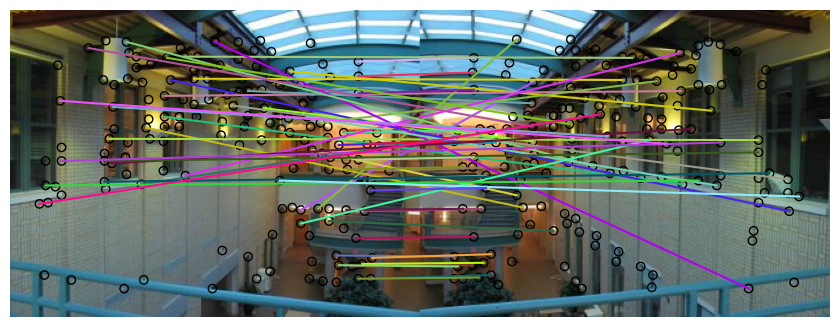

In [2]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

## Problem 1
### Rederive your formula in Problem 4a from Part I of the assignment for the following modification. Assume there are $N=53$ matches $(p,p')$ as in figure 1 above. $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=32$ outliers. To estimate a homography you need a sample with $K=4$ matches. What is the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution:

**Solution:**

Given:
- $N$: total number of points, where $N = 53$
- $N_i$: number of inliner points, where $N_i = 21$
- $N_o$: number of outlier points, where $N_o = 32$
- $p$: desired probability we want, where $p \geq 0.95$
- $K$: Number of matches needed for homography estimation, $K = 4$
- $n$: The least number of samples or iterations required to achieve probability $p \geq 0.95$

Then, 
- $p_i$: probability of choosing one inliner point is given as $p_i = \frac{N_i}{N}$
- $p_o$: probability of choosing one outlier point is given as $p_o = \frac{N_o}{N}$

Thus, the probability of choosing K inliners is $p_i^K = \frac{N_i}{N}^K$, as $K = 4$. 

Deriving the formula: 
- We want to find the least number of times $n$ we must sample a subset of $K$ matches to achieve a probability $p$ that one of these samples has all of its $K$ matches from inliners. 
- The probability of selecting an inliner on a single draw in $p_i$
- The probability of selecting a set of $K$ inliners in one sample is $p_i^K$, assuming that events are independent.
- The probability of not selecting a set of $K$ inliners in one sample is $p_o = 1 - p_i^K$
- The probability of not selecting a set of $K$ inliners in $n$ independed samples is $(1 - p_i^K)^n$

$\therefore$ The probability $p$ of selecting at least one set of $s$ inliners in $k$ samples is the complement of the above given as: $$ p = 1 - (1 - p_i^K)^n $$ 

Formula: $$ p = 1 - (1 - p_i^K)^n $$ 

Solving for $k$:
$$
\begin{align}
p = 1 - (1 - p_i^K)^n \\
(1 - p_i^K)^n = 1 - p \\
\log((1 - p_i^K)^n) = \log(1 - p) \\
n \log(1 - p_i^K) = \log(1 - p) \\
\therefore \boxed{n = \frac{\log(1 - p)}{\log(1 - p_i^K)}}
\end{align}
$$

Computing a numerical answer for the given:
- $N = 53$
- $N_i = 21$
- $N_o = 32$
- $p = 0.95$
- $k = 4$

1. Calculate $p_i$
$$
\begin{align}
p_i = \frac{N_i}{N} = \frac{21}{53} = 0.3962264151 \\
\therefore p_i = 0.3962264151
\end{align}
$$

2. Calculate $k$
$$
\begin{align}
n = \frac{\log(1 - p)}{\log(1 - p_i^K)} 
  = \frac{\log(1 - 0.95)}{\log(1 - (0.3962264151)^4)} 
  = \frac{-1.301029996}{-0.01083841937} = 120.03872707 \approx 121 \\
\therefore \boxed{k= 121}
\end{align}
$$

Thus, we need at least $ k = 121$ iterations to have $p \geq 0.95$

## Problem 2: (RANSAC for Homographies)
### Write code below using RANSAC to estimate Homography from matched pairs of points above. This cell should display new figure 2 similar to figure 1 above, but it should show only inlier pairs for the detected homography. HINT: you can use $ProjectiveTransform$  from library $skimage$ declared at the top of the notebok.

Trials: 88


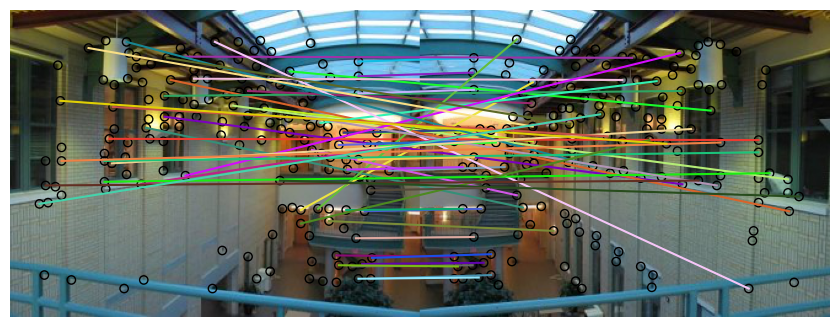

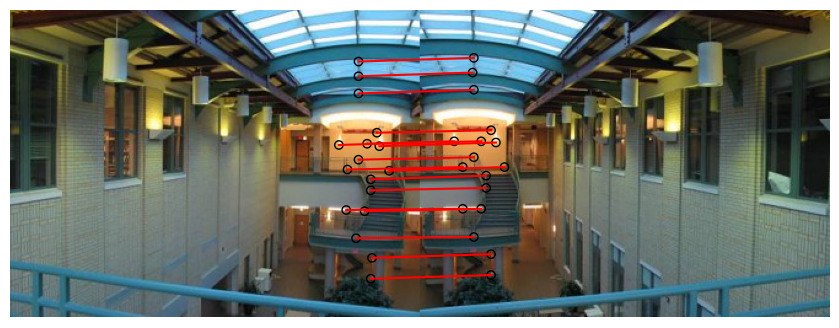

In [3]:
# function to calculate the minimum number of trials for p >= 0.95
def num_iterations(p, K, N_i, N):
    p_i = N_i/N
    trials = math.log(1 - p) / (math.log(1 - (p_i ** K)))
    return math.ceil(trials)

# calculate number of trials
N = 56
Ni = 24
No = 32
p = 0.95
K = 4
trials = num_iterations(p, K, Ni, N)
print(f'Trials: {trials}')

# Load keypoints matches from both the left and right images
key_matches_L = keypointsL[matchesLR[:,0]]
key_matches_R = keypointsR[matchesLR[:,1]]

# Running RANSAC to robustly estimate a homography transform between matched keypoints
model_robust, inliners = ransac((key_matches_L, key_matches_R), ProjectiveTransform, min_samples = K, 
                                residual_threshold = 2.5, max_trials = trials)

# initializing an empty list to hold the matches
matches =[]
# Iterate through the inliners and append the match indicies to the 'matches' list
for i in range(len(key_matches_L[inliners])):
    matches.append([i, i])
    
# Reshaping the array to a 2-column format for plotting
matches = np.reshape(matches, (len(matches), 2))

# plotting the matches before RANSAC filtering
fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')
plt.show()

# plotting inliners for the detected homography
fig = plt.figure(2, figsize=(12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, key_matches_L[inliners], key_matches_R[inliners], matches, matches_color = 'r')
axA.axis('off')
plt.show()

## Problem 3 (reprojecting onto common PP)
### Use common PP corresponding to the plane of the left image. Your pamorama mosaic should be build inside a "reference frame" (think about it as an empty canvas of certain size) inside this common PP. The reference frame should be big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP. Create a new figure 3 including the following three images (spread them vertically). First, show your reference frame only with the left image inside. Second, show the reference frame containing only a reprojected right image (warp it using a homography computed in Problem 1). Third, for comparison, show the reference frame containing only the right image reprojected using a (bad) homography estimated from all matches (including outliers, as in figure 1).
#### HINT1: use function $warp$ from library $skimage$ declared at the top of the notebook. 
#### HINT2: function $warp$ needs "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

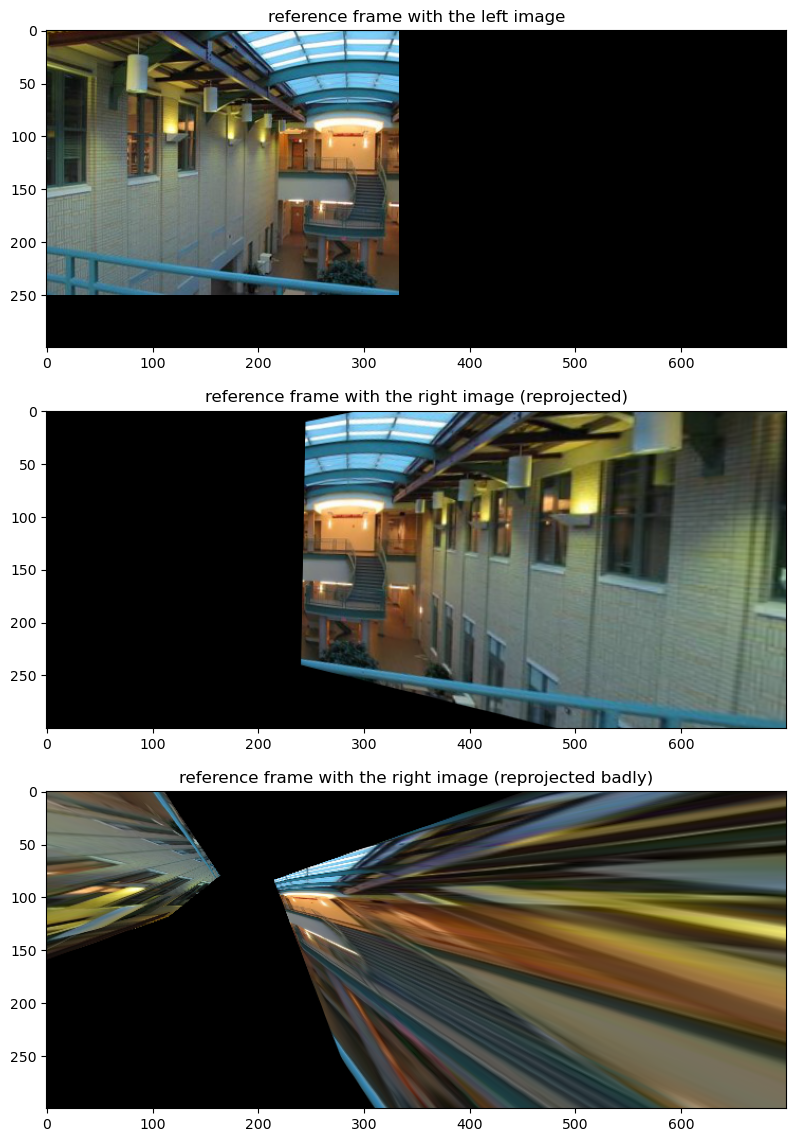

In [4]:
# Creating an empty image array with dimensions 300x700 and 3 color channels for RGB
imgL = np.zeros([300, 700, 3])
# Normalizingthe left image's pixel values
imgL[: len(imL), : len(imL[0])] = imL/255

# Warp the right image using the robust homography model 
imgT = warp(imR.transpose((1, 0, 2)), model_robust, output_shape = (700, 300))
imgR = imgT.transpose((1, 0, 2)) # transposing the warped image to match the original orientation 


# Perform RANSAC with a bad homography model
mode_robust_bad, inliners_bad = ransac((key_matches_L, key_matches_R), ProjectiveTransform, min_samples = 4,
                                      residual_threshold = 5, max_trials = 10)

# Creating projective transform object for the bad homography
model_bad_projective_transform = ProjectiveTransform()
# Estimate the projective transform from the bad key matches
model_bad_projective_transform.estimate(key_matches_L, key_matches_R)
# Warp the right image using the bad homography model
img_bad_T = warp(imR.transpose((1, 0, 2)), model_bad_projective_transform, output_shape = (700, 300))
# Transpose the warped image to match the original orientation
img_bad = img_bad_T.transpose((1, 0, 2))

# for left image
fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
plt.imshow(imgL)
plt.title("reference frame with the left image")

# for re projected right image
plt.subplot(312)
plt.imshow(imgR)
plt.title("reference frame with the right image (reprojected)")

# for reprojected right image with bad homography
plt.subplot(313)
plt.imshow(img_bad)
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

## Problem 4 (blending)

### (part a) Write code for a function below computing distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values). 
   

In [5]:
    def boundaryDT(image):
        distances = np.zeros((len(image), len(image[0])))
        height = len(image) - 1
        width = len(image[0]) - 1
       
        for i in range(height + 1):
            for j in range(width + 1):
                min_row = min(i, height - i)
                min_col = min(j, width - j)
                distances[i][j] = float(min(min_row, min_col) + 0.5)
        return distances

### (part b) Use function from part (a) to compute a distance transform for both images. Create a new figure 4 showing the following two images. First, show reference frame containing only the left image's boundaryDT instead of the left image. Second, show reference frame containing only the right image's boundaryDT reprojected instead of the right image. 

Text(0.5, 1.0, 'Right image DT in Ref. frame (RdtRef)')

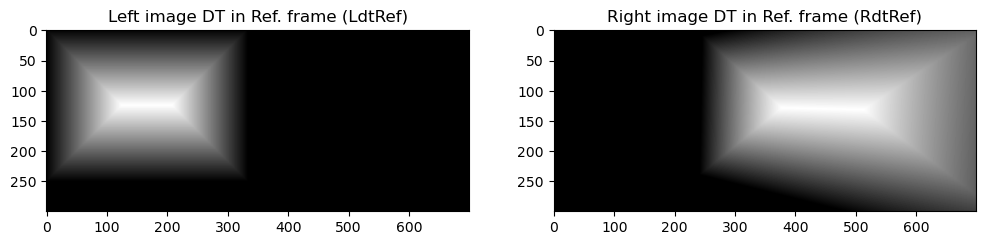

In [6]:
# Initialize an empty array of zeros 
left_image = np.zeros([300, 700])
# compute the distance transform of the left image
leftDT = boundaryDT(imL)
# copy the distance transform of the left image into the array for left_image
left_image[: len(leftDT), :len(leftDT[0])] = leftDT

# compute distance transform for right image
rightDT = boundaryDT(imR)
# wrap the right image's distance transform using robust homography
right_image = warp(rightDT.transpose(), model_robust, output_shape = (700, 300))
right_image = right_image.transpose()

# Plot distance transform for left image
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
plt.imshow(left_image)
plt.title("Left image DT in Ref. frame (LdtRef)")

# Plot distance transform for right image
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(122)
plt.imshow(right_image)
plt.title("Right image DT in Ref. frame (RdtRef)")

### (part c) Use boundary distance transforms to blend left and right images (reprojected) into the reference frame. Create a new figure 5 showing the following three images. The first and second images should be smooth $alpha$'s suitable for blending the left and right images (e.g. based on distance transforms as discussed in class). The third image should be your panorama: left and (reprojected) right images blended inside the reference frame. Your panorama should also show (reprojected) features - homography inliers - from both left and right images. Use different colors/shapes to distinct features from the left and the right images.

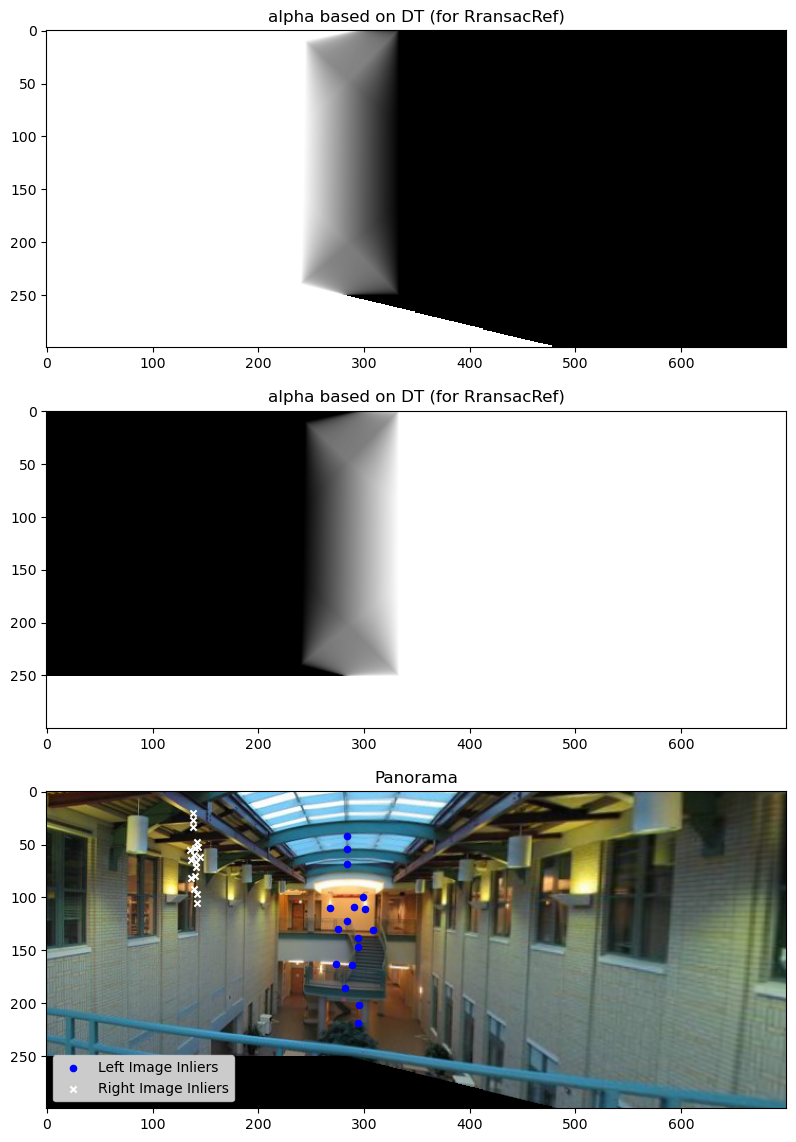

In [7]:
np.seterr(divide='ignore', invalid='ignore')

alpha_L = left_image / (left_image + right_image)
alpha_R = right_image / (left_image + right_image)

alpha_L_shape = alpha_L.reshape((len(alpha_L), len(alpha_L[0]), 1))
alpha_R_shape = alpha_R.reshape((len(alpha_R), len(alpha_R[0]), 1))

image = alpha_L_shape * imgL + alpha_R_shape * imgR

right_inliners = np.ones((key_matches_R[inliners].shape[0], 3))
right_inliners[:,:2] = key_matches_R[inliners]
right_points = np.dot(right_inliners, np.linalg.inv(model_robust.params).T)

fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)
plt.imshow(alpha_L)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(312)
plt.imshow(alpha_R)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(313)
plt.imshow(image)
plt.title("Panorama")
plt.scatter(key_matches_L[inliners][:, 1], key_matches_L[inliners][:, 0], s = 20,c = 'blue', marker ='o', label = 'Left Image Inliers')
plt.scatter(right_points[:,1], right_points[:,0], s = 20, c = 'white', marker = 'x', label = 'Right Image Inliers')
plt.legend(loc = 'lower left')

plt.show()